# Import everything

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Normalization

In [3]:
df = pd.read_csv('Austin_data.csv', low_memory=False)

Get only the relevant columns

In [4]:
relevant_columns = [
    'property_zip', 'longitude_x', 'latitude_x', 'latitude_y', 'longitude_y','township', 'township_name_x', 'nbhd', 'tract_geoid',
    'tract_pop', 'tract_white_perc', 'commissioner_dist', 'reps_dist',
    'senate_dist', 'ward', 'school_elem_district_x', 'PIN',
    'Property Class', 'Neighborhood Code', 'Land Square Feet', 'Town Code', 'Prior Tax Year Market Value Estimate (Land)',
    'Prior Tax Year Market Value Estimate (Building)', 'Multi Property Indicator', 'Age',
    'Use', 'Multi-Family Indicator', 'Near Major Road', 'Location Factor',
    'Private Service Line Material', 'Public Service Line Material', 'Neigborhood Code (mapping)', 'Town and Neighborhood',
    'property_city'
]

In [ ]:
# Using this to make simpler

# relevant_columns = [
#     'Draw1', 'Draw2', 'Draw3', 'Max', 'longitude', 'latitude',
#     'Private Service Line Material', 'Public Service Line Material'
# ]

In [5]:
df = df[relevant_columns]

In [6]:
# Using only "LEAD" and "NOT LEAD"
df = df[(df['Private Service Line Material'].isin(['LEAD', 'NOT LEAD'])) &
        (df['Public Service Line Material'].isin(['LEAD', 'NOT LEAD']))]


numeric columns with median

In [7]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=[object]).columns

numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])


categorical variables

In [8]:
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

Normalize numeric features

In [9]:
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

-----------------------------------------------------------------------

# **K-means cluster**

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df[relevant_columns].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = df.groupby('Cluster')[relevant_columns].mean()

print("Cluster Centers:")
print(cluster_centers)
print("\nCluster Summary:")
print(cluster_summary)

Cluster Centers:
[[ 4.56693979e+03  5.95345687e-01  7.99911626e-01  1.74272516e+04
   6.72055394e+03  4.47827352e-01  3.13479146e+00  4.62939020e-02
   9.79166584e-02  1.91830582e-01  7.63392662e-01  7.03838716e-01
   1.39498536e-01  1.33117875e-01  8.66066342e-01  1.50833188e+02
   4.80760263e-01  8.15892837e-01  7.72601263e-02  9.39428262e-02
   9.00929828e-01  2.99484204e-02  7.23341517e-02  1.64638634e-02
   2.86094503e-01  8.26958293e-02  2.29330321e-03  2.24452773e-01
   6.18584686e-01  9.84152248e-01  9.72052506e-01  7.72601263e-02
   8.56878038e-02  0.00000000e+00]
 [ 6.10469920e+02  6.94114537e-01  6.61436413e-01  9.38537249e+03
   2.86404554e+03  5.96170922e-01  4.17319646e+00  1.45940317e-02
   1.10985567e-01  2.71686849e-01  7.48269808e-01  6.53744902e+00
   2.54787991e-01  2.47471301e-01  5.67210903e-01  2.39610519e+02
   5.95251072e-01  9.93043073e-01  2.44505886e-02  9.95114752e-02
   9.27500550e-01  1.22033307e-02  6.68899449e-02  7.24940941e-15
   1.73729845e-01 -2.199

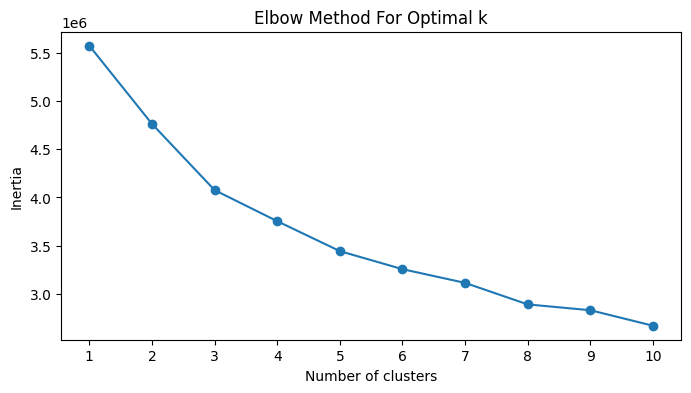

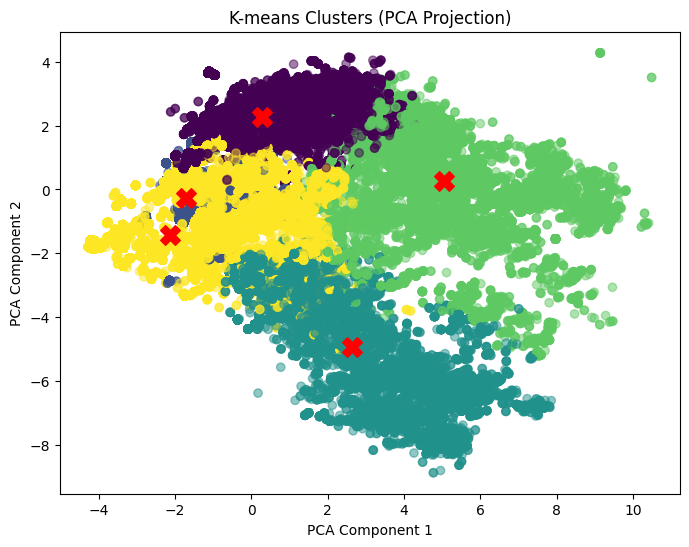

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Diagram 1: Elbow Plot ---
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)  # using the scaled data
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.show()

# --- Diagram 2: PCA Projection of Clusters ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

cluster_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title("K-means Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, marker='X')
plt.show()


In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)

indices = np.random.choice(range(len(X_scaled)), size=1000, replace=False)
subset = X_scaled[indices]
subset_labels = kmeans.labels_[indices]

print("Unique clusters in subset:", np.unique(subset_labels))

silhouette_avg = silhouette_score(subset, subset_labels)
print(f"Silhouette Score: {silhouette_avg}")

ch_score = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Score: {ch_score}")

inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)



Unique clusters in subset: [0 1 2 3 4]
Silhouette Score: 0.0942679596313009
Silhouette Score: 0.0942679596313009
Calinski-Harabasz Score: 153955.09065973328


# **Neural Networks with Dense and Dropout**

In [12]:
X = df.drop(['Private Service Line Material', 'Public Service Line Material'], axis=1)
y_private = df['Private Service Line Material']
y_public = df['Public Service Line Material']

In [13]:
X_train, X_test, y_private_train, y_private_test, y_public_train, y_public_test = train_test_split(
    X, y_private, y_public, test_size=0.2, random_state=42
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout


y_private_train_cat = to_categorical(y_private_train)
y_private_test_cat = to_categorical(y_private_test)
y_public_train_cat = to_categorical(y_public_train)
y_public_test_cat = to_categorical(y_public_test)

# Define the model
def create_model1(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model1(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model1(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8628 - loss: 14.4254 - val_accuracy: 0.9065 - val_loss: 0.2515
Epoch 2/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9062 - loss: 0.2966 - val_accuracy: 0.9065 - val_loss: 0.2453
Epoch 3/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9086 - loss: 0.2654 - val_accuracy: 0.9065 - val_loss: 0.2310
Epoch 4/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9089 - loss: 0.2463 - val_accuracy: 0.9065 - val_loss: 0.2292
Epoch 5/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9091 - loss: 0.2389 - val_accuracy: 0.9065 - val_loss: 0.2237
Epoch 6/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9099 - loss: 0.2319 - val_accuracy: 0.9065 - val_loss: 0.2164
Epoch 7/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9102 - loss: 0.2275 - val_accuracy: 0.9072 - val_loss: 0.2185
Epoch 8/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9107 - loss: 0.

In [19]:
loss_private, acc_private = private_model.evaluate(X_test, y_private_test_cat, verbose=0)
print("Private Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_private, acc_private))

loss_public, acc_public = public_model.evaluate(X_test, y_public_test_cat, verbose=0)
print("Public Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_public, acc_public))


Private Model - Loss: 0.3056, Accuracy: 0.9087
Public Model - Loss: 0.2391, Accuracy: 0.8931


# **Neaural Networks model-2**

In [14]:
def create_model2(input_shape, output_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),  # Increase dropout slightly to prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model2(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model2(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3381/3381 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8630 - loss: 28.2867 - val_accuracy: 0.9065 - val_loss: 0.2688
Epoch 2/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9090 - loss: 0.3003 - val_accuracy: 0.9065 - val_loss: 0.2580
Epoch 3/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9095 - loss: 0.2887 - val_accuracy: 0.9065 - val_loss: 0.3155
Epoch 4/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9089 - loss: 0.3001 - val_accuracy: 0.9065 - val_loss: 0.3107
Epoch 5/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9102 - loss: 0.3036 - val_accuracy: 0.9065 - val_loss: 0.3107
Epoch 6/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9090 - loss: 0.3054 - val_accuracy: 0.9065 - val_loss: 0.3106
Epoch 7/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9092 - loss: 0.3054 - val_accuracy: 0.9065 - val_loss: 0.3106
Epoch 8/10
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9085 - loss: 0.3142 - val_

In [ ]:
loss_private, acc_private = private_model.evaluate(X_test, y_private_test_cat, verbose=0)
print("Private Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_private, acc_private))

loss_public, acc_public = public_model.evaluate(X_test, y_public_test_cat, verbose=0)
print("Public Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_public, acc_public))

# **LeakyRelU**

In [ ]:
from keras.layers import LeakyReLU

def create_model3(input_shape, output_shape):
    model = Sequential([
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model3(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model3(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7065 - loss: 1.0632 - val_accuracy: 0.7598 - val_loss: 0.4537
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8409 - loss: 0.5110 - val_accuracy: 0.8676 - val_loss: 0.3977
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8645 - loss: 0.4546 - val_accuracy: 0.8676 - val_loss: 0.3943
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8554 - loss: 0.4102 - val_accuracy: 0.8676 - val_loss: 0.4065
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8741 - loss: 0.3936 - val_accuracy: 0.8676 - val_loss: 0.3811
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8848 - loss: 0.3209 - val_accuracy: 0.8676 - val_loss: 0.3856
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.3707 - val_accuracy: 0.8676 - val_loss: 0.3741
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8587 - loss: 0.3558 - val_accuracy: 0.8676 - val_loss: 0.3725
Epo

In [ ]:
# For model one only
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Private Service Line Material Classification Report:")
print(classification_report(y_private_test, private_pred_classes))
print("\nPrivate Service Line Material Confusion Matrix:")
print(confusion_matrix(y_private_test, private_pred_classes))


print("\nPublic Service Line Material Classification Report:")
print(classification_report(y_public_test, public_pred_classes))
print("\nPublic Service Line Material Confusion Matrix:")
print(confusion_matrix(y_public_test, public_pred_classes))

# Function to predict service line material
def predict_service_line(model, X):
    pred = model.predict(X)
    pred_classes = np.argmax(pred, axis=1)
    return le.inverse_transform(pred_classes)

# Example prediction
sample_data = X_test.iloc[:5]  # Take first 5 samples for demonstration
private_predictions = predict_service_line(private_model, sample_data)
public_predictions = predict_service_line(public_model, sample_data)

print("\nSample Predictions:")
print("Private Service Line Material:", private_predictions)
print("Public Service Line Material:", public_predictions)

Private Service Line Material Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.88      1.00      0.93       447

    accuracy                           0.88       510
   macro avg       0.44      0.50      0.47       510
weighted avg       0.77      0.88      0.82       510


Private Service Line Material Confusion Matrix:
[[  0  63]
 [  0 447]]

Public Service Line Material Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48       152
           1       0.78      0.74      0.76       358

    accuracy                           0.67       510
   macro avg       0.62      0.63      0.62       510
weighted avg       0.68      0.67      0.68       510


Public Service Line Material Confusion Matrix:
[[ 78  74]
 [ 94 264]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Sample Predictions:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
